# Get 1 good MSD per trial for a given folder of tip trajectories
Tim Tyree<br>
12.18.2020

In [4]:
from lib.my_initialization import *

%autocall 1
%load_ext autoreload
%autoreload 2
# awareness&chill

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#make plots work in darkmode
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# collect, unwrap, and center the n_tips=1 longest trajectories in a folder of trajectories

In [130]:
#find file interactively
print("please select a file from within the desired folder.")
file = search_for_file()

please select a file from within the desired folder.
File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8_fastkernel_V_0.6_archive/trajectories/ic_200x200.001.13_traj_sr_400_mem_2.csv


In [145]:
def produce_one_csv(list_of_files, file_out):
   # Consolidate all csv files into one object
   result_obj = pd.concat([pd.read_csv(file) for file in list_of_files])
   # Convert the above object into a csv file and export
   result_obj.to_csv(file_out, index=False, encoding="utf-8")

In [146]:

# def run_routine(ic):
#     pass
#     output_file_name = preprocess_log(ic)
#     return output_file_name

In [147]:
# b = db.from_sequence(file_name_list, npartitions=10).map(run_routine)
# start = time.time()
# retval = list(b)
# print(f"run time for generating birth-death rates from file_name_list: {time.time()-start:.2f} seconds.")
# beep(3)

In [148]:
# ic = file_name_list[0]

In [221]:
# input_file_name = "/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8_fastkernel_V_0.4_archive/Log/ic_200x200.001.11_log.csv"
# output_file_name = preprocess_log(ic)
df.drop?

In [246]:
def compute_emsd_for_longest_trajectories(input_file_name,n_tips = 1,DS = 5/200,DT = 1., round_t_to_n_digits=0):
    #select the longest n trajectories
    df = pd.read_csv(input_file_name)
    df.reset_index(inplace=True)
    s = df.groupby('particle').t.count()
    s = s.sort_values(ascending=False)
    pid_longest_lst = list(s.index.values[:n_tips])
    #     df_traj = pd.concat([df[df.particle==pid] for pid in pid_longest_lst])

    #truncate trajectories to their first apparent jump (pbc jumps should have been removed already)
    df_lst = []
    for pid in  pid_longest_lst:#[2:]:
        d = df[(df.particle==pid)].copy()
        x_values, y_values = d[['x','y']].values.T 
        index_values = d.index.values.T 
        jump_index_array, spd_lst = find_jumps(x_values,y_values,width=200,height=200, DS=5/200,DT=1, jump_thresh=20.)#.25)
        if len(jump_index_array)>0:
            ji = jump_index_array[0]
            d.drop(index=index_values[ji:], inplace=True)
        df_lst.append(d)
    df_traj = pd.concat(df_lst)
        
    #round trajectory times to remove machine noise from floating point arithmatic
    df_traj['t'] = df_traj.t.round(round_t_to_n_digits)
#     assert ( (np.array(sorted(set(df_traj['particle'].values)))==np.array(sorted(pid_longest_lst))).all())
    #compute ensemble mean squared displacement
    emsd = trackpy.motion.emsd(df_traj, mpp=1., fps=1.,max_lagtime=40000)
    #cast ensemble mean squared displacement into units of cm^2 and seconds
    return pd.DataFrame({'msd':DS**2*emsd.values, 'lagt':emsd.index.values*DT/10**3, 'src':input_file_name})




In [247]:
def compute_average_msd(df, DT=1.):
    src_lst = sorted(set(df.src.values))
    src_lst = src_lst#[:10]
    ff = df.copy()#pd.concat([df[df.src==src] for src in src_lst])
    dt = DT/10**3
    t_values = np.array(sorted(set(ff.lagt.values)))
    t_values = np.arange(np.min(t_values),np.max(t_values),dt)
    # averaging msd over trials
    msd_lst = []
    for t in t_values:
        boo = (ff.lagt>=t-dt/2)&(ff.lagt<=t+dt/2)
        msd_lst.append(ff[boo].msd.mean())
    t_values = t_values
    msd_values = np.array(msd_lst)
    return t_values, msd_values

def PlotMSD(df, t_values, msd_values, savefig_folder,savefig_fn,xlim = [0,0.05],ylim=[0,4],D = 75,saving = True,fontsize =22,figsize=(9,6)):
    '''plot msd for each trial listed in df.src. also plot average msd.'''
    #compute average msd by trial for a subset of trials    
    fig, ax = plt.subplots(figsize=figsize)
    # x_values = ef.index.values#*DT/10**3 #lag in seconds
    # y_values = ef.values#*DS**2 #msd
    
    for src in src_lst:
        x_values = df[df.src==src].lagt.values
        y_values = df[df.src==src].msd.values
        ax.plot(x_values,y_values,c='blue',alpha=0.2)
    ax.plot(t_values,msd_values,c='g',lw=2)
    ax.plot(t_values,t_values*D,c='r',lw=2)

    # DS = 5/200 #cm per pixel
    # DT = 1. #ms per frame
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('lag (s)', fontsize=fontsize)
    ax.set_ylabel(r'MSD (cm$^2$)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=0)
    if not saving: 
        plt.show() 
    else:
        plt.tight_layout()
        os.chdir(savefig_folder)
        plt.savefig(savefig_fn, dpi=300)
        print(f"saved figure in \n\t{savefig_fn}")
        plt.close()
    return {'t':t_values,'msd':msd_values}

In [248]:
def generate_msd_figures_routine(file,n_tips):
    V_thresh = eval(file[file.find('_V_')+len('_V_'):].split('_')[0])
    # get all .csv files in the working directory of ^that file
    folder_name = os.path.dirname(file)
    os.chdir(folder_name)
    retval = !ls
    file_name_list = list(retval)
    # check each file if it ends in .csv before merging it
    def is_csv(file_name):
        return file_name[-4:]=='.csv'
    file_name_list = [f for f in file_name_list if is_csv(f)]
    # remove all files with 'threshold'
    # file_name_list = [f for f in file_name_list if f.find('threshold')==-1]
        
    print(f"Num. file names in list = {len(file_name_list)}.")
    #compute ensemble mean squared displacement for the longest n_tips for each trial in file_name_list
    os.chdir(folder_name)
    df = pd.concat([compute_emsd_for_longest_trajectories(input_file_name, n_tips=n_tips) for input_file_name in file_name_list])
    df.reset_index(inplace=True,drop=True)
    #save results
    dirname = os.path.dirname(file).split('/')[-1]
    save_folder = folder_name.replace(dirname,'msd')
    os.chdir(save_folder)
    output_file_name = f"emsd_longest_by_trial_tips_ntips_{n_tips}.csv"
    df.to_csv(output_file_name, index=False)

    #compute average msd by trial for a subset of trials
    src_lst = sorted(set(df.src.values))
    src_lst = src_lst#[:10]

    ff = df.copy()#pd.concat([df[df.src==src] for src in src_lst])

    dt = DT/10**3
    t_values = np.array(sorted(set(ff.lagt.values)))
    t_values = np.arange(np.min(t_values),np.max(t_values),dt)

    # averaging msd over trials
    msd_lst = []
    for t in t_values:
        boo = (ff.lagt>=t-dt/2)&(ff.lagt<=t+dt/2)
        msd_lst.append(ff[boo].msd.mean())

    t_values = t_values
    msd_values = np.array(msd_lst)

    t_values, msd_values = compute_average_msd(df, DT=1.)
    savefig_folder = os.path.join(nb_dir,f'Figures/msd/V_{V_thresh}')

    # generate plots of msd's
    savefig_fn = os.path.basename(output_file_name).replace('.csv','_long_time.png')
    retval = PlotMSD(df, t_values, msd_values, savefig_folder,savefig_fn,xlim = [0,4],ylim=[0,10],saving = True,fontsize =22,figsize=(9,6),D=3.5)

    savefig_fn = os.path.basename(output_file_name).replace('.csv','_short_time.png')
    retval = PlotMSD(df, t_values, msd_values, savefig_folder,savefig_fn,xlim = [0,0.2],ylim=[0,1],saving = True,fontsize =22,figsize=(9,6),D=3.5)

    savefig_fn = os.path.basename(output_file_name).replace('.csv','_very_short_time.png')
    retval = PlotMSD(df, t_values, msd_values, savefig_folder,savefig_fn,xlim = [0,0.05],ylim=[0,0.2],saving = True,fontsize =22,figsize=(9,6),D=3.5)
    return ff, retval

# beep(4)

# compute msd for the longest lasting tip in each trajectory in each folder

In [202]:
# input_file_name = file_name_list[0]
# input_file_name


'trajectories_unwrapped'

In [251]:
#find file interactively
print("please select a file from within the desired folder.")
file = search_for_file()

please select a file from within the desired folder.
File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8_fastkernel_V_0.6_archive/trajectories_unwrapped/ic_200x200.001.21_traj_sr_400_mem_2.csv


In [252]:
# n_tips = 50
ff, retval = generate_msd_figures_routine(file,n_tips=1)
# ff, retval = generate_msd_figures_routine(file,n_tips=2 )
# ff, retval = generate_msd_figures_routine(file,n_tips=15 )
ff, retval = generate_msd_figures_routine(file,n_tips=50  )
beep(10)

Num. file names in list = 171.
saved figure in 
	emsd_longest_by_trial_tips_ntips_1_long_time.png
saved figure in 
	emsd_longest_by_trial_tips_ntips_1_short_time.png
saved figure in 
	emsd_longest_by_trial_tips_ntips_1_very_short_time.png
Num. file names in list = 171.
saved figure in 
	emsd_longest_by_trial_tips_ntips_50_long_time.png
saved figure in 
	emsd_longest_by_trial_tips_ntips_50_short_time.png
saved figure in 
	emsd_longest_by_trial_tips_ntips_50_very_short_time.png


0

In [191]:
file

'/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8_fastkernel_V_0.6_archive/trajectories/ic_200x200.001.13_traj_sr_400_mem_2.csv'

## plot some msd plots (routine automated)

saved figure in 
	emsd_longest_by_trial_tips_ntips_15_long_time.svg


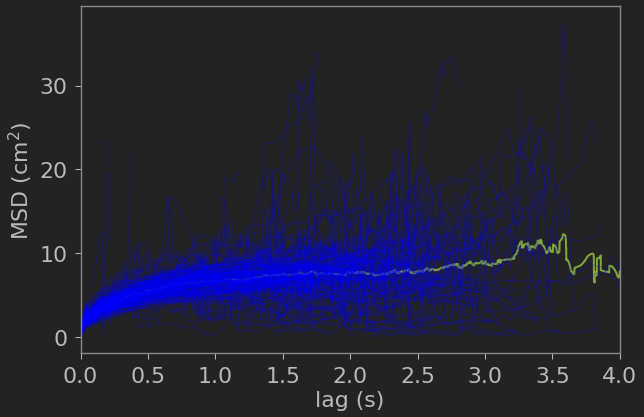

In [173]:
# plot msd for each trial
saving = True
savefig_fn = os.path.basename(output_file_name).replace('.csv','_long_time.svg')
savefig_folder = os.path.join(nb_dir,f'Figures/msd/V_{V_thresh}')
fontsize =22
figsize=(9,6)

fig, ax = plt.subplots(figsize=figsize)
# x_values = ef.index.values#*DT/10**3 #lag in seconds
# y_values = ef.values#*DS**2 #msd
ax.plot(t_values,msd_values,c='g',lw=2)

for src in src_lst:
    x_values = df[df.src==src].lagt.values
    y_values = df[df.src==src].msd.values
    ax.plot(x_values,y_values,c='blue',alpha=0.2)
# DS = 5/200 #cm per pixel
# DT = 1. #ms per frame
# D = 1/0.013
# ax.plot(t_values,t_values*D,c='r',lw=2)

ax.set_xlim([0,4])
ax.set_xlabel('lag (s)', fontsize=fontsize)
ax.set_ylabel(r'MSD (cm$^2$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")

saved figure in 
	emsd_longest_by_trial_tips_ntips_15_short_time.svg


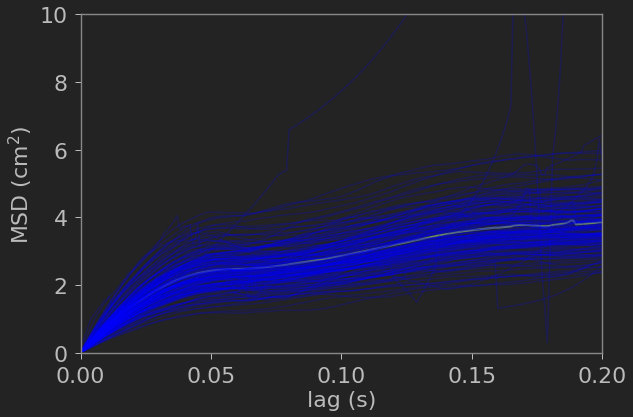

In [176]:
# plot msd for each trial
saving = True
savefig_fn = os.path.basename(output_file_name).replace('.csv','_short_time.svg')
savefig_folder = os.path.join(nb_dir,f'Figures/msd/V_{V_thresh}')
fontsize =22
figsize=(9,6)

fig, ax = plt.subplots(figsize=figsize)
# x_values = ef.index.values#*DT/10**3 #lag in seconds
# y_values = ef.values#*DS**2 #msd
ax.plot(t_values,msd_values,c='g',lw=2)

for src in src_lst:
    x_values = df[df.src==src].lagt.values
    y_values = df[df.src==src].msd.values
    ax.plot(x_values,y_values,c='blue',alpha=0.2)
# DS = 5/200 #cm per pixel
# DT = 1. #ms per frame
D = 1/0.013
ax.plot(t_values,t_values*D,c='r',lw=2)


ax.set_xlim([0,.2])
ax.set_ylim([0,10])
ax.set_xlabel('lag (s)', fontsize=fontsize)
ax.set_ylabel(r'MSD (cm$^2$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")

saved figure in 
	emsd_longest_by_trial_tips_ntips_15_very_short_time.svg


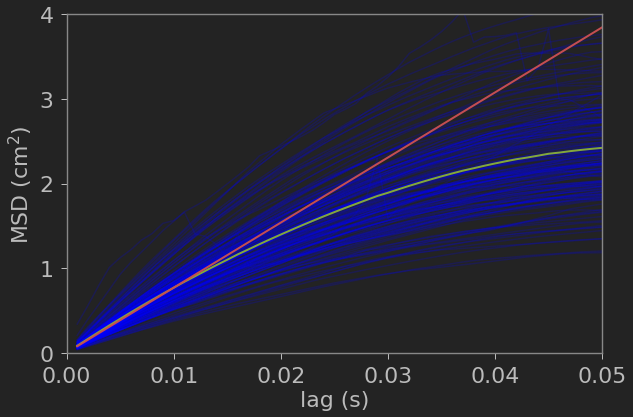

In [178]:
# plot msd for each trial
saving = True
# V_thresh = 0.4
savefig_fn = os.path.basename(output_file_name).replace('.csv','_very_short_time.svg')
savefig_folder = os.path.join(nb_dir,f'Figures/msd/V_{V_thresh}')
fontsize =22
figsize=(9,6)
fig, ax = plt.subplots(figsize=figsize)
# x_values = ef.index.values#*DT/10**3 #lag in seconds
# y_values = ef.values#*DS**2 #msd

for src in src_lst:
    x_values = df[df.src==src].lagt.values
    y_values = df[df.src==src].msd.values
    ax.plot(x_values,y_values,c='blue',alpha=0.2)
# DS = 5/200 #cm per pixel
# DT = 1. #ms per frame
ax.plot(t_values,msd_values,c='g',lw=2)
D = 1/0.013
ax.plot(t_values,t_values*D,c='r',lw=2)


ax.set_xlim([0,.05])
ax.set_ylim([0,4])
ax.set_xlabel('lag (s)', fontsize=fontsize)
ax.set_ylabel(r'MSD (cm$^2$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")

# TODO: look closely at those many of the longest tips that have very small MSD for the first 0.05 seconds
- TODO: flower plot for that trial/those trials

# Turn all ^this into a function and run it on a few n_tips and over all three V_threshold values I have data for

In [169]:
# savefig_fn = os.path.basename(output_file_name).replace('.csv','_very_short_time.svg')
# savefig_folder = os.path.join(nb_dir,f'Figures/msd/V_{V_thresh}')
# PlotMSD(df, xlim = [0,0.05],ylim=[0,4],DT=1.,saving = True,fontsize =22,figsize=(9,6))

saved figure in 
	emsd_longest_by_trial_tips_ntips_2_very_short_time.svg


{'t': array([1.000e-03, 2.000e-03, 3.000e-03, ..., 4.009e+00, 4.010e+00,
        4.011e+00]),
 'msd_avg': array([0.07777242, 0.15443327, 0.23017724, ..., 9.85460146, 9.90454823,
        5.3103621 ])}

# TODO: try adding a filter to the longest trajectory on the basis of speed
- before computing which is longest? --> complicated
- after computing which is simplest? --> simple and extensible

In [214]:
# ff

In [212]:
# x_values = df_traj.x.values
# y_values = df_traj.y.values

# jump_index_array, spd_lst = find_jumps(x_values,y_values,width=200,height=200, DS=5/200,DT=1, jump_thresh=None)

# jump_index_array

array([845])

## TODO: make a function that lops off msd if it jumps by more than a certain amount.